The input data is spread over 3 separate files - `churn_data.csv`, `cust_data.csv` and `internet_data.csv`. 

The Data includes the following: 

- `Personal Data (gender, children, whether senior citizen, dependents...)`
- `Services Related (Tenure with the provider, payment method, internet packs purchased, special offers...)`
- `Charges being incurred (Amount of recharge done per month...)`

In [36]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import statsmodels.api as smd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import scipy.stats as st
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt 
import seaborn as sns
import sqlite3
from sqlite3 import Error
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [37]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [38]:
conn = create_connection('telecom.db')
cursor = conn.cursor()
commands = [
    '''CREATE TABLE IF NOT EXISTS CustomerData (
        customerID TEXT PRIMARY KEY,
        gender TEXT,
        SeniorCitizen INTEGER,
        Partner TEXT,
        Dependents TEXT
    )''',
    '''CREATE TABLE IF NOT EXISTS InternetData (
        customerID TEXT PRIMARY KEY,
        MultipleLines TEXT,
        InternetService TEXT,
        OnlineSecurity TEXT,
        OnlineBackup TEXT,
        DeviceProtection TEXT,
        TechSupport TEXT,
        StreamingTV TEXT,
        StreamingMovies TEXT,
        FOREIGN KEY(customerID) REFERENCES CustomerData(customerID)
    )''',
    '''CREATE TABLE IF NOT EXISTS ChurnData (
        customerID TEXT PRIMARY KEY,
        tenure INTEGER,
        PhoneService TEXT,
        Contract TEXT,
        PaperlessBilling TEXT,
        PaymentMethod TEXT,
        MonthlyCharges REAL,
        TotalCharges REAL,
        Churn TEXT,
        FOREIGN KEY(customerID) REFERENCES CustomerData(customerID)
    )'''
]

for command in commands:
    cursor.execute(command)

conn.commit()
conn.close()

In [39]:
def insert_csv_data(conn, file_path, table_name):

    with open(file_path, newline='') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        data = [row for row in reader]
    
    placeholders = ', '.join(['?'] * len(data[0]))

    command = f'INSERT INTO {table_name} VALUES ({placeholders})'

    cursor = conn.cursor()
    cursor.executemany(command, data)
    conn.commit()

def execute_database_operations():
    conn = create_connection('telecom.db')
    if conn is None:
        return "Failed to create database connection."
    try:

        clear_commands = [
            'DELETE FROM CustomerData',
            'DELETE FROM InternetData',
            'DELETE FROM ChurnData'
        ]
        
        cursor = conn.cursor()
        for command in clear_commands:
            cursor.execute(command)

        insert_csv_data(conn, 'customer_data.csv', 'CustomerData')

        insert_csv_data(conn, 'internet_data.csv', 'InternetData')

        insert_csv_data(conn, 'churn_data.csv', 'ChurnData')

        conn.commit()

    except sqlite3.Error as e:
        conn.rollback()  
        return f"An error occurred: {e}"
    finally:
        if conn:
            conn.close()  

    return "Data loaded and inserted successfully with proper connection management."

result = execute_database_operations()
print(result)

An error occurred: FOREIGN KEY constraint failed


In [40]:
conn = create_connection('telecom.db')
query = "select * from churnData"
churn_data = pd.read_sql_query(query, conn)
conn.close()
churn_data.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [41]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 495.3+ KB


In [42]:
conn = create_connection('telecom.db')
query = "select * from customerData"
customer_data = pd.read_sql_query(query, conn)
conn.close()
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [43]:
conn = create_connection('telecom.db')
query = "select * from internetData"
internet_data = pd.read_sql_query(query, conn)
conn.close()
internet_data.head()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


In [44]:
conn = create_connection('telecom.db')
query = """
SELECT 
    ChurnData.customerID,
    ChurnData.tenure,
    ChurnData.PhoneService,
    ChurnData.Contract,
    ChurnData.PaperlessBilling,
    ChurnData.PaymentMethod,
    ChurnData.MonthlyCharges,
    ChurnData.TotalCharges,
    ChurnData.Churn,
    CustomerData.gender,
    CustomerData.SeniorCitizen,
    CustomerData.Partner,
    CustomerData.Dependents,
    InternetData.MultipleLines,
    InternetData.InternetService,
    InternetData.OnlineSecurity,
    InternetData.OnlineBackup,
    InternetData.DeviceProtection,
    InternetData.TechSupport,
    InternetData.StreamingTV,
    InternetData.StreamingMovies
FROM ChurnData
INNER JOIN CustomerData ON ChurnData.customerID = CustomerData.customerID
INNER JOIN InternetData ON ChurnData.customerID = InternetData.customerID;

"""

telecom = pd.read_sql_query(query, conn)
conn.close()

In [45]:
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [46]:
telecom.columns

Index(['customerID', 'tenure', 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [47]:
telecom.shape

(7043, 21)

In [48]:
telecom.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


In [49]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


In [50]:
telecom['TotalCharges'] = telecom['TotalCharges'].replace(' ', np.nan)
telecom['TotalCharges'] = pd.to_numeric(telecom['TotalCharges'])

In [51]:
charge = telecom['MonthlyCharges'] * telecom['tenure']

In [52]:
telecom['TotalCharges'] = charge.where(telecom['TotalCharges'] == np.nan, other=telecom['TotalCharges'])

In [53]:
telecom['TotalCharges']

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [54]:
train,test= train_test_split(telecom, train_size=0.7, test_size=0.3, random_state=100)

In [35]:
from ydata_profiling import ProfileReport
profile = ProfileReport(train, title='Profiling Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [55]:
train['Churn'].value_counts()

Churn
No     3627
Yes    1303
Name: count, dtype: int64

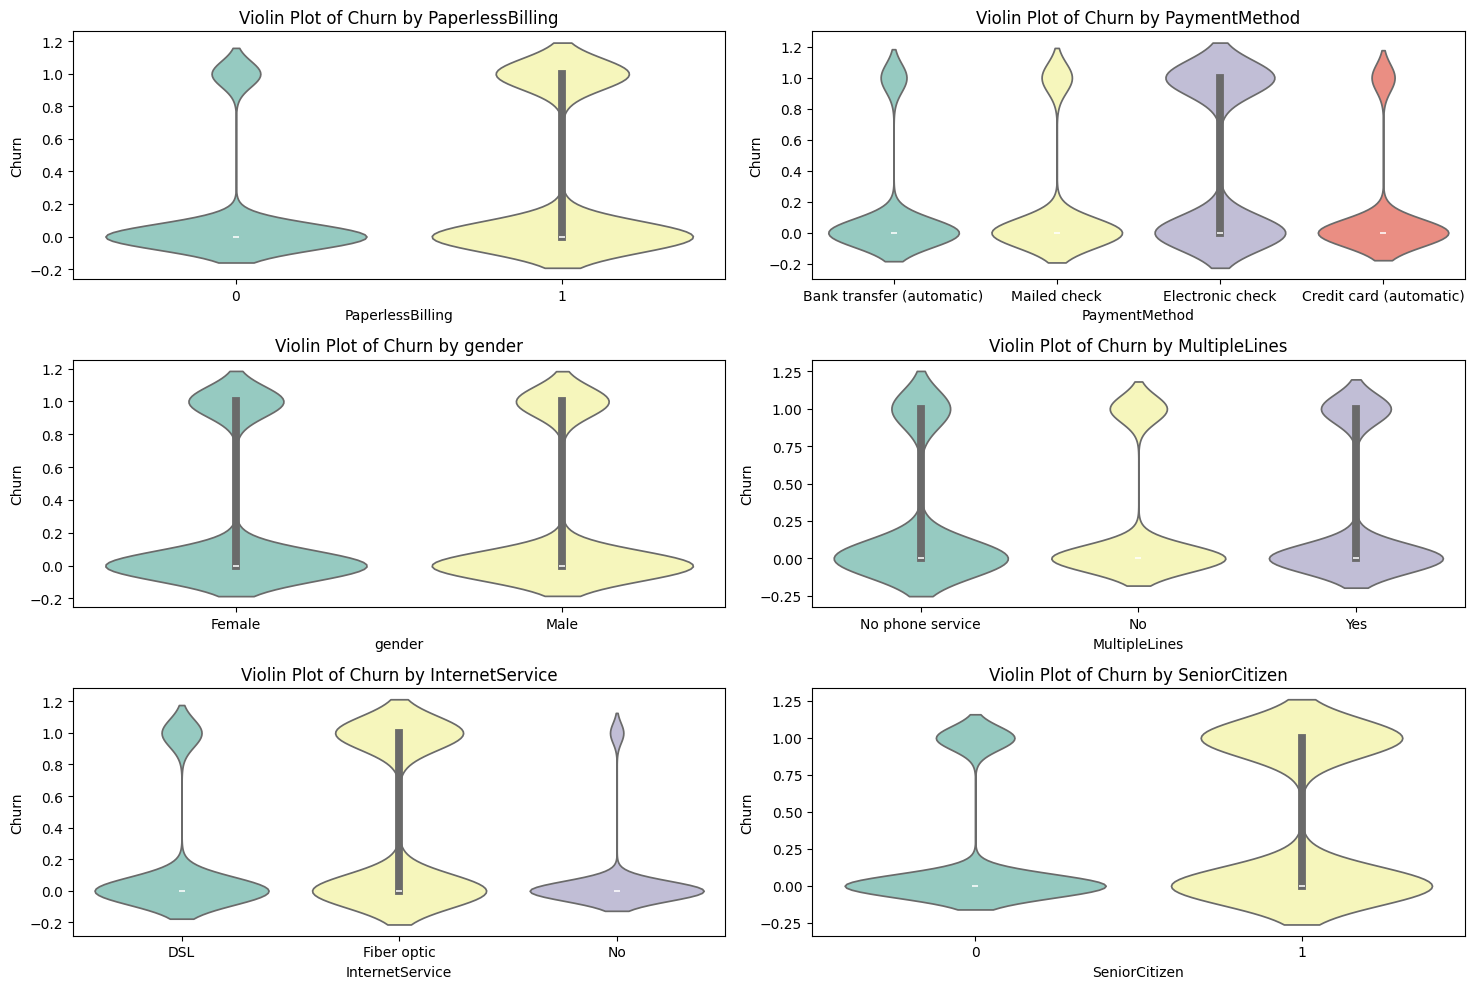

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame
# Assuming 'train' is already loaded with the target 'Churn' and the specified categorical variables

# List of categorical variables
categorical_vars = ['PaperlessBilling', 'PaymentMethod', 'gender', 'MultipleLines', 'InternetService','SeniorCitizen']

# Create a figure and set of subplots with a specified size
plt.figure(figsize=(15, 10))

# Loop through the list of categorical variables to create a violin plot for each
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(3, 2, i)  # Adjust the grid dimensions depending on the number of variables
    sns.violinplot(x=var, y='Churn', data=train, palette='Set3')
    plt.title(f'Violin Plot of Churn by {var}')
    plt.xlabel(var)
    plt.ylabel('Churn')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [56]:
class Preprocessor(BaseEstimator, TransformerMixin): 
    # Train our custom preprocessors 
    numerical_columns = [
        
        'tenure','MonthlyCharges','TotalCharges',  
    ]
    
    categorical_columns = [
        'Contract', 'PaymentMethod', 'gender',
        'InternetService', 'MultipleLines', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport',
        'StreamingTV', 'StreamingMovies',
    ]
    
    
    def fit(self, X, y=None): 

        # Create and fit simple imputer
        self.imputer = SimpleImputer(strategy='median')
        self.imputer.fit(X[self.numerical_columns])
        
        # Create and fit Standard Scaler 
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.numerical_columns]) 
        
        # Create and fit one hot encoder
        self.onehot = OneHotEncoder(handle_unknown='ignore')
        self.onehot.fit(X[self.categorical_columns])
        
        return self 

    def transform(self, X): 
        
        # Apply simple imputer 
        imputed_cols = self.imputer.transform(X[self.numerical_columns])
        onehot_cols = self.onehot.transform(X[self.categorical_columns])
        
        # Copy the df 
        transformed_df = X.copy()
         
        # Apply transformed columns
        transformed_df[self.numerical_columns] = imputed_cols
        transformed_df[self.numerical_columns] = self.scaler.transform(transformed_df[self.numerical_columns])        
        
        # Drop existing categorical columns and replace with one hot equivalent
        transformed_df = transformed_df.drop(self.categorical_columns, axis=1) 
        transformed_df[self.onehot.get_feature_names_out()] = onehot_cols.toarray().astype(int)
        
        return transformed_df

In [57]:
train.drop(['customerID'],axis=1,inplace=True)
test.drop(['customerID'],axis=1,inplace=True)

In [58]:
varlist =  ['PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents']
def binary_map(x):
    return x.map({'Yes': int(1), "No": 0})

train[varlist] = train[varlist].apply(binary_map)
test[varlist] = test[varlist].apply(binary_map)

In [59]:
train.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
877,51,0,One year,0,Bank transfer (automatic),60.15,3077.00,0,Female,0,0,1,No phone service,DSL,Yes,No,Yes,Yes,Yes,Yes
5792,15,1,Month-to-month,1,Mailed check,96.30,1426.75,1,Female,1,0,0,No,Fiber optic,Yes,No,Yes,Yes,No,Yes
5334,49,1,Two year,1,Bank transfer (automatic),107.95,5293.20,1,Female,0,1,1,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
878,60,1,One year,0,Electronic check,64.75,4039.50,0,Female,0,0,0,Yes,DSL,Yes,No,Yes,Yes,No,No
6578,10,1,One year,0,Credit card (automatic),73.55,693.30,0,Female,0,0,1,Yes,DSL,Yes,No,Yes,Yes,No,Yes


In [60]:
preprocessor = Preprocessor()
preprocessor.fit(train)
train_fixed = preprocessor.transform(train)

In [61]:
train_fixed

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,Contract_Month-to-month,...,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes
877,0.754422,0,0,-0.145568,0.348921,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,1
5792,-0.710751,1,1,1.051796,-0.380014,1,1,0,0,1,...,1,0,0,1,1,0,0,0,0,1
5334,0.673024,1,1,1.437668,1.327842,1,0,1,1,0,...,1,0,0,1,0,0,1,0,0,1
878,1.120716,1,0,0.006794,0.774068,0,0,0,0,0,...,1,0,0,1,1,0,0,1,0,0
6578,-0.914247,1,0,0.298268,-0.703987,0,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.510227,1,1,-1.279999,-0.472839,0,0,1,1,0,...,0,0,1,0,0,1,0,0,1,0
3927,-1.199142,1,1,-1.457203,-0.987632,1,0,1,0,1,...,0,0,1,0,0,1,0,0,1,0
5955,1.609107,1,0,0.127689,1.134438,0,0,1,1,0,...,0,0,0,1,0,0,1,1,0,0
6936,-1.117744,1,1,0.516874,-0.840167,1,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0


In [62]:
train_fixed.isnull().sum()

tenure                                     0
PhoneService                               0
PaperlessBilling                           0
MonthlyCharges                             0
TotalCharges                               0
Churn                                      0
SeniorCitizen                              0
Partner                                    0
Dependents                                 0
Contract_Month-to-month                    0
Contract_One year                          0
Contract_Two year                          0
PaymentMethod_Bank transfer (automatic)    0
PaymentMethod_Credit card (automatic)      0
PaymentMethod_Electronic check             0
PaymentMethod_Mailed check                 0
gender_Female                              0
gender_Male                                0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
MultipleLines_No                           0
MultipleLi

Now we don't have any missing values

In [63]:
from sklearn.ensemble import RandomForestClassifier

rfc = make_pipeline(Preprocessor(), RandomForestClassifier(n_estimators=50))

In [64]:
rfc

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=50))])

In [65]:
y_train = train['Churn']
X_train = train.drop('Churn', axis=1)
rfc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=50))])

In [66]:
params = rfc.get_params()
params 

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('randomforestclassifier', RandomForestClassifier(n_estimators=50))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'randomforestclassifier': RandomForestClassifier(n_estimators=50),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n_estimators': 50,
 'randomforestclassifier__n_jobs': None,
 'randomforestclassifier__oob_score': False,
 'randomforestclassifier__random_stat

In [67]:
y_test = test['Churn']
X_test = test.drop('Churn', axis=1)
y_pred = rfc.predict(X_test)

In [68]:
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
cm = confusion_matrix(y_test, y_pred)

Confusion Matrix:
[[1378  169]
 [ 283  283]]


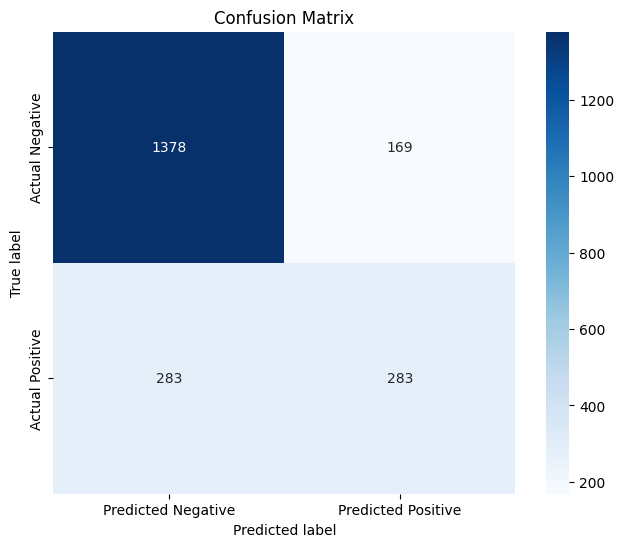

In [69]:
print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', square=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [70]:
import mlflow
from mlflow.models import infer_signature
import os

MLFLOW_TRACKING_URI="https://dagshub.com/sainathaytla983/SPRING2024_CLASSIFICATION.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="sainathaytla983"
os.environ['MLFLOW_TRACKING_PASSWORD']="605476eef802c15febbf0482987ceb7e2b30ed01"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Predict If a Customer Churns")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric("accuracy_score", accuracy)
    mlflow.log_metric("balanced_accuracy_score", balanced_accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision_score", precision)
    mlflow.log_metric("recall_score", recall)
    mlflow.log_metric("roc_auc_score", roc_auc)
   # mlflow.log_metric("confusion_matrix", cm)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "RandomForestClassifier model for telecom data, n_estimators=50")

    # Infer the model signature
    signature = infer_signature(X_train, rfc.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rfc,
        artifact_path="classification_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="rfc_model_base",
    )

2024/05/16 10:15:27 INFO mlflow.tracking.fluent: Experiment with name 'Predict If a Customer Churns' does not exist. Creating a new experiment.
Successfully registered model 'rfc_model_base'.
2024/05/16 10:24:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: rfc_model_base, version 1
Created version '1' of model 'rfc_model_base'.


In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# Assuming you have a preprocessing class or function named 'Preprocessor'
pipeline = make_pipeline(Preprocessor(), RandomForestClassifier())

param_grid = {
    'randomforestclassifier__n_estimators': [10, 50],  # number of trees in the forest
    'randomforestclassifier__max_features': ['sqrt', 'log2'],  # number of features to consider when looking for the best split
    'randomforestclassifier__max_depth': [10, 20],  # maximum depth of the tree
    'randomforestclassifier__min_samples_split': [5, 10],  # minimum number of samples required to split an internal node
    'randomforestclassifier__min_samples_leaf': [2, 4]  # minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Best parameters found: ", grid_search.best_params_)

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
best_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
cm = confusion_matrix(y_test, y_pred)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters found:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 50}


In [73]:
params = pipeline.get_params()
params

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'randomforestclassifier': RandomForestClassifier(),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__n_jobs': None,
 'randomforestclassifier__oob_score': False,
 'randomforestclassifier__random_state': None,
 'randomforestclass

In [75]:
import mlflow
from mlflow.models import infer_signature
import os

MLFLOW_TRACKING_URI="https://dagshub.com/sainathaytla983/SPRING2024_CLASSIFICATION.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="sainathaytla983"
os.environ['MLFLOW_TRACKING_PASSWORD']="605476eef802c15febbf0482987ceb7e2b30ed01"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Predict If a Customer Churns")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric("accuracy_score", accuracy)
    mlflow.log_metric("balanced_accuracy_score", balanced_accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision_score", precision)
    mlflow.log_metric("recall_score", recall)
    mlflow.log_metric("roc_auc_score", roc_auc)
   # mlflow.log_metric("confusion_matrix", cm)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info Improved", "RandomForestClassifier improved model for telecom data")

    # Infer the model signature
    signature = infer_signature(X_train, rfc.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="classification_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="rfc_model_improved",
    )

Successfully registered model 'rfc_model_improved'.
2024/05/16 10:46:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: rfc_model_improved, version 1
Created version '1' of model 'rfc_model_improved'.


In [76]:
log_reg = make_pipeline(
    Preprocessor(),
    LogisticRegression(C=0.1, solver='liblinear', max_iter=200)
)

log_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=200, solver='liblinear'))])

In [77]:
params = log_reg.get_params()
y_test = test['Churn']
X_test = test.drop('Churn', axis=1)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
cm = confusion_matrix(y_test, y_pred)

In [78]:
import mlflow
from mlflow.models import infer_signature
import os

MLFLOW_TRACKING_URI="https://dagshub.com/sainathaytla983/SPRING2024_CLASSIFICATION.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="sainathaytla983"
os.environ['MLFLOW_TRACKING_PASSWORD']="605476eef802c15febbf0482987ceb7e2b30ed01"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Predict If a Customer Churns")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric("accuracy_score", accuracy)
    mlflow.log_metric("balanced_accuracy_score", balanced_accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision_score", precision)
    mlflow.log_metric("recall_score", recall)
    mlflow.log_metric("roc_auc_score", roc_auc)
   # mlflow.log_metric("confusion_matrix", cm)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Logistic Regression Base Model")

    # Infer the model signature
    signature = infer_signature(X_train, log_reg.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="classification_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="log_reg_base_model",
    )

Successfully registered model 'log_reg_base_model'.
2024/05/16 10:56:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: log_reg_base_model, version 1
Created version '1' of model 'log_reg_base_model'.


In [79]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Assuming the same Preprocessor class/function is used for preprocessing the data
pipeline = make_pipeline(Preprocessor(), LogisticRegression())

# Define a parameter grid to search over
param_grid = {
    'logisticregression__C': [0.1, 1, 10],  # Regularization strength
    'logisticregression__solver': ['liblinear', 'lbfgs'],  # Solvers
    'logisticregression__max_iter': [100, 200]  # Maximum number of iterations to converge
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Assuming 'train' is your DataFrame and 'Churn' is the target variable
y_train = train['Churn']
X_train = train.drop('Churn', axis=1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score obtained from the grid search
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Optionally, you can retrieve the best estimator directly
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

params = pipeline.get_params()
accuracy = accuracy_score(y_test, y_pred)
best_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
cm = confusion_matrix(y_test, y_pred)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'lbfgs'}
Best cross-validation score: 0.81


In [80]:
import mlflow
from mlflow.models import infer_signature
import os

MLFLOW_TRACKING_URI="https://dagshub.com/sainathaytla983/SPRING2024_CLASSIFICATION.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="sainathaytla983"
os.environ['MLFLOW_TRACKING_PASSWORD']="605476eef802c15febbf0482987ceb7e2b30ed01"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Predict If a Customer Churns")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric("accuracy_score", accuracy)
    mlflow.log_metric("balanced_accuracy_score", balanced_accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision_score", precision)
    mlflow.log_metric("recall_score", recall)
    mlflow.log_metric("roc_auc_score", roc_auc)
   # mlflow.log_metric("confusion_matrix", cm)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info Optimized", "Logistic Regression Optimized Model")

    # Infer the model signature
    signature = infer_signature(X_train, rfc.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="classification_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="log_reg_optimized_model",
    )

Successfully registered model 'log_reg_optimized_model'.
2024/05/16 11:07:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: log_reg_optimized_model, version 1
Created version '1' of model 'log_reg_optimized_model'.


In [ ]:
import json
import requests

payload = json.dumps({'inputs': {
  'tenure': 51 , 'PhoneService': 0 , 'Contract': 'One year', 
  'PaperlessBilling': 0 , 'PaymentMethod': 'Bank transfer (automatic)' , 'MonthlyCharges': 60.15,
  'TotalCharges': 3077.00, 'gender': 'Female', 'SeniorCitizen': 1, 
  'Partner': 0, 'Dependents': 1, 'MultipleLines': 'No phone service', 
  'InternetService': 'DSL', 'OnlineSecurity': 'Yes', 'OnlineBackup': 'No', 
  'DeviceProtection': 'Yes', 'TechSupport': 'Yes', 'StreamingTV': 'Yes', 'StreamingMovies': 'Yes' 
}})
response = requests.post(
    url=f"http://localhost:5000/invocations",
    data=payload,
    headers={"Content-Type": "application/json"},
)
print(response.json())

In [81]:
# Check the corr values of final list of variables
cor = train_fixed.corr()
cor

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,Contract_Month-to-month,...,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes
tenure,1.000000,0.007254,0.000012,0.252985,0.824411,-0.351045,0.018955,0.377802,0.154035,-0.644926,...,0.362992,-0.262776,-0.054979,0.338757,-0.241461,-0.054979,0.289502,-0.239084,-0.054979,0.285863
PhoneService,0.007254,1.000000,0.017400,0.241879,0.111705,0.009099,-0.001291,0.024788,-0.000039,-0.009441,...,-0.065283,-0.066532,0.175804,-0.087651,-0.115304,0.175804,-0.034597,-0.106354,0.175804,-0.043727
PaperlessBilling,0.000012,0.017400,1.000000,0.352970,0.153208,0.201021,0.162176,-0.028613,-0.121860,0.177701,...,0.098469,0.243060,-0.327219,0.032244,0.052701,-0.327219,0.226984,0.069613,-0.327219,0.209655
MonthlyCharges,0.252985,0.241879,0.352970,1.000000,0.654223,0.195659,0.217867,0.099652,-0.105994,0.052045,...,0.488468,0.323754,-0.770902,0.349207,0.034034,-0.770902,0.625259,0.033601,-0.770902,0.624258
TotalCharges,0.824411,0.111705,0.153208,0.654223,1.000000,-0.200607,0.099016,0.315662,0.068343,-0.449940,...,0.526278,-0.087312,-0.385623,0.448346,-0.192424,-0.385623,0.523095,-0.189911,-0.385623,0.518869
Churn,-0.351045,0.009099,0.201021,0.195659,-0.200607,1.000000,0.170374,-0.148178,-0.170862,0.411128,...,-0.065543,0.361844,-0.234604,-0.182826,0.144831,-0.234604,0.055244,0.144798,-0.234604,0.055481
SeniorCitizen,0.018955,-0.001291,0.162176,0.217867,0.099016,0.170374,1.000000,0.021033,-0.208897,0.149629,...,0.062975,0.215939,-0.182811,-0.069979,0.043921,-0.182811,0.112273,0.041788,-0.182811,0.114235
Partner,0.377802,0.024788,-0.028613,0.099652,0.315662,-0.148178,0.021033,1.000000,0.454913,-0.283804,...,0.156932,-0.111548,-0.002982,0.125195,-0.131342,-0.002982,0.134443,-0.115871,-0.002982,0.118350
Dependents,0.154035,-0.000039,-0.121860,-0.105994,0.068343,-0.170862,-0.208897,0.454913,1.000000,-0.227998,...,0.011171,-0.171447,0.135245,0.064609,-0.106124,0.135245,-0.009121,-0.080488,0.135245,-0.034968
Contract_Month-to-month,-0.644926,-0.009441,0.177701,0.052045,-0.449940,0.411128,0.149629,-0.283804,-0.227998,1.000000,...,-0.225091,0.431451,-0.202940,-0.288190,0.292411,-0.202940,-0.120040,0.288581,-0.202940,-0.115240


In [45]:
# Find out the Fields with high correlation

correlated_features = set()
for i in range(len(cor.columns)):
    for j in range(i):
        if abs(cor.iloc[i, j]) > 0.7:
            colname1 = cor.columns[i]
            colname2 = cor.columns[j]
            print(abs(cor.iloc[i, j]), "--", i, '--', j, '--', colname1, '--', colname2)
            correlated_features.add(colname1)
            correlated_features.add(colname2)

0.8258804609332019 -- 4 -- 0 -- TotalCharges -- tenure
0.7871948529419366 -- 15 -- 3 -- InternetService_Fiber optic -- MonthlyCharges
0.7631910615169536 -- 16 -- 3 -- InternetService_No -- MonthlyCharges
1.0000000000000002 -- 17 -- 1 -- MultipleLines_No phone service -- PhoneService
0.7631910615169536 -- 19 -- 3 -- OnlineSecurity_No internet service -- MonthlyCharges
1.0 -- 19 -- 16 -- OnlineSecurity_No internet service -- InternetService_No
0.7631910615169536 -- 21 -- 3 -- OnlineBackup_No internet service -- MonthlyCharges
1.0 -- 21 -- 16 -- OnlineBackup_No internet service -- InternetService_No
1.0 -- 21 -- 19 -- OnlineBackup_No internet service -- OnlineSecurity_No internet service
0.7631910615169536 -- 23 -- 3 -- DeviceProtection_No internet service -- MonthlyCharges
1.0 -- 23 -- 16 -- DeviceProtection_No internet service -- InternetService_No
1.0 -- 23 -- 19 -- DeviceProtection_No internet service -- OnlineSecurity_No internet service
1.0 -- 23 -- 21 -- DeviceProtection_No interne

In [46]:
print(cor.columns)
print('------')
print(correlated_features)

Index(['tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'SeniorCitizen', 'Partner', 'Dependents',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'InternetService_Fiber optic', 'InternetService_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes'],
      dtype='object')
------
{'InternetService_No', 'OnlineBackup_No internet service', 'TechSupport_No internet service', 'StreamingMovies_No internet servi

#### Dropping highly correlated dummy variables

### Repeat the Correlation Matrix/Heatmap

<Figure size 2000x1000 with 0 Axes>

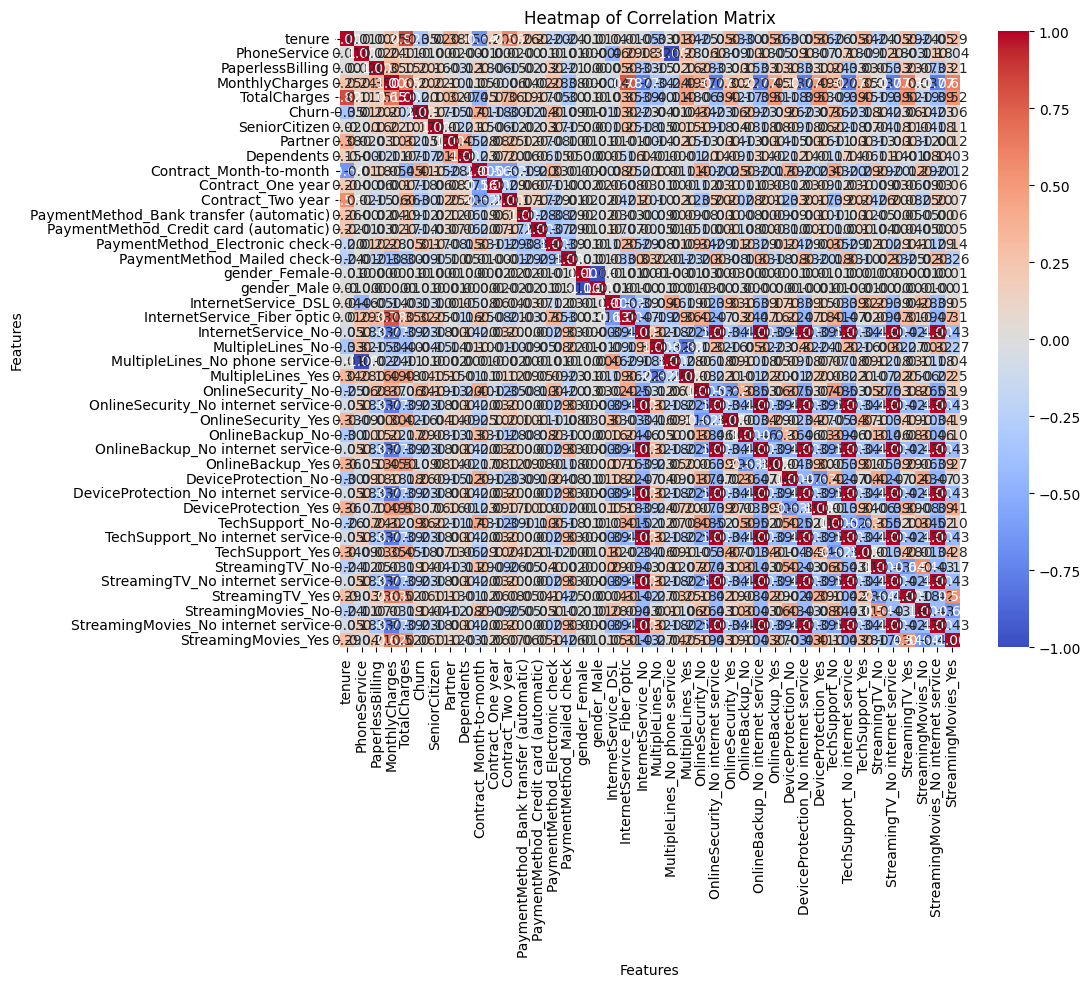

In [82]:
plt.figure(figsize = (20,10))
corr = train_fixed.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Add title and labels for clarity
plt.title('Heatmap of Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [86]:

corr_matrix = train_fixed.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than a threshold (e.g., 0.9)
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop highly correlated features
df_reduced = train_fixed.drop(to_drop, axis=1)

# Split the data into training and testing sets
X = df_reduced.drop('Churn', axis=1)  # Feature matrix
y = df_reduced['Churn']  # Target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of the Random Forest model:", accuracy)
print("Dropped columns:", to_drop)


Accuracy of the Random Forest model: 0.7795807978363759
Dropped columns: ['gender_Male', 'MultipleLines_No phone service', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']


In [87]:
params = rf.get_params()
accuracy = accuracy_score(y_test, y_pred)
best_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
cm = confusion_matrix(y_test, y_pred)

In [88]:
import mlflow
from mlflow.models import infer_signature
import os

MLFLOW_TRACKING_URI="https://dagshub.com/sainathaytla983/SPRING2024_CLASSIFICATION.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="sainathaytla983"
os.environ['MLFLOW_TRACKING_PASSWORD']="605476eef802c15febbf0482987ceb7e2b30ed01"

mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

mlflow.set_experiment("Predict If a Customer Churns")

with mlflow.start_run():
    mlflow.log_params(params)

    mlflow.log_metric("accuracy_score", accuracy)
    mlflow.log_metric("balanced_accuracy_score", balanced_accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision_score", precision)
    mlflow.log_metric("recall_score", recall)
    mlflow.log_metric("roc_auc_score", roc_auc)

    mlflow.set_tag("Reduced Model", "Random Forest Reduced Model")

    # Infer the model signature
    signature = infer_signature(X_train, rf.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rf,
        artifact_path="classification_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="RFC Reduced Model",
    )

Successfully registered model 'RFC Reduced Model'.
2024/05/16 11:58:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RFC Reduced Model, version 1
Created version '1' of model 'RFC Reduced Model'.
